# ColPali + Qdrant Retrieval Pipeline for a Single PDF

This notebook converts every page of a single PDF into images, embeds them with ColPali, and stores the embeddings in a local Qdrant instance for retrieval.


## 1. Setup & Imports
Install required dependencies, import modules, and configure the compute device.


In [2]:
%pip install --upgrade --quiet torch pdf2image Pillow matplotlib tqdm qdrant-client colpali-engine

import os
from pathlib import Path

import torch
from pdf2image import convert_from_path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from colpali_engine.models import ColPali, ColPaliProcessor
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance, PointStruct

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Using device: mps


## 2. Configuration
Set paths and runtime parameters for the pipeline.


In [3]:
PDF_PATH = "./data/presentation.pdf"  # Update with the actual PDF path
OUTPUT_IMAGE_DIR = "./data/pdf_pages"
QDRANT_URL = "http://localhost:6333"
QDRANT_COLLECTION = "pdf_pages"
BATCH_SIZE = 2

output_dir_path = Path(OUTPUT_IMAGE_DIR)
output_dir_path.mkdir(parents=True, exist_ok=True)

print(f"PDF path: {os.path.abspath(PDF_PATH)}")
print(f"Image output directory: {output_dir_path.resolve()}")


PDF path: /Users/gmanvel/repos/rag-genai-dbs-codex/data/presentation.pdf
Image output directory: /Users/gmanvel/repos/rag-genai-dbs-codex/data/pdf_pages


## 3. Convert PDF Pages to Images
Render each page of the PDF to a PNG image and capture metadata for later steps.


In [4]:
def convert_pdf_to_images(pdf_path: str, output_dir: str) -> list[dict]:
    """Convert each page of the PDF into a PNG image on disk."""
    pdf_path = Path(pdf_path)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    images = convert_from_path(str(pdf_path))

    page_records: list[dict] = []
    base_name = pdf_path.stem

    for idx, image in enumerate(images):
        file_name = f"page_{idx + 1:04d}.png"
        image_path = output_path / file_name
        image.save(image_path, format="PNG")

        page_records.append(
            {
                "page_index": idx,
                "image_path": str(image_path.resolve()),
                "pdf_file_name": base_name,
            }
        )

    return page_records


Converted 20 pages to images.


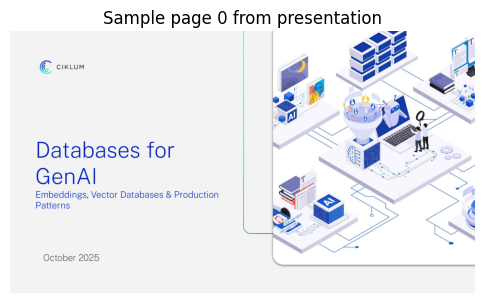

In [5]:
pages = convert_pdf_to_images(PDF_PATH, OUTPUT_IMAGE_DIR)
print(f"Converted {len(pages)} pages to images.")

if pages:
    with Image.open(pages[0]["image_path"]) as sample_image:
        plt.figure(figsize=(6, 8))
        plt.imshow(sample_image)
        plt.axis("off")
        plt.title(f"Sample page 0 from {pages[0]['pdf_file_name']}")
        plt.show()
else:
    print("No pages were generated. Check the PDF path.")


## 4. Load ColPali Model
Load the ColPali processor and model for generating image and text embeddings.


In [6]:
model_name = "vidore/colpali-v1.2"
processor = ColPaliProcessor.from_pretrained(model_name)

preferred_dtype = torch.bfloat16 if device.type in {"cuda", "mps"} else torch.float32

try:
    model = ColPali.from_pretrained(
        model_name,
        torch_dtype=preferred_dtype,
    )
except Exception as error:
    print(f"Falling back to float32 due to: {error}")
    preferred_dtype = torch.float32
    model = ColPali.from_pretrained(
        model_name,
        torch_dtype=preferred_dtype,
    )

model = model.to(device)
model.eval()

print(f"Model loaded with dtype {preferred_dtype} on {device}.")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 18.22it/s]


Model loaded with dtype torch.bfloat16 on mps.


## 5. Embed Page Images
Batch process the saved page images through ColPali to create embeddings and metadata.


### Page Embedding Strategy (Mean Pooling)

ColPali produces multiple embedding vectors per page image. Conceptually, it splits the page into many visual regions / patches and gives us an embedding for each region.  
That means for a single PDF page we may get something like 1,000+ vectors, each 128-dimensional.

For our use case we want **page-level retrieval**:
- A search query (text) should bring back the *whole* page image.
- We don't need sub-page / bounding-box precision.

To achieve that, we collapse all region embeddings for a page into **one** page embedding by taking the mean across all region vectors (mean pooling).  
This gives us a single 128-dim vector that represents the entire page's visual/semantic content.

We then:
1. Store exactly one vector per page in Qdrant,
2. Attach metadata (`page_index`, `pdf_file_name`, `image_path`),
3. Later, when we search, Qdrant returns the most relevant page.

This keeps Qdrant small (1 point per page) and aligns with our "retrieve a whole page to display" requirement.


In [7]:
import torch
from PIL import Image
from pathlib import Path
from tqdm import tqdm


def embed_pages_mean_pooled(
    pages,
    model,
    processor,
    batch_size: int,
    device: torch.device
):
    """
    pages: list[dict] from convert_pdf_to_images(), where each item has:
        {
            "page_index": int,
            "image_path": str,
            "pdf_file_name": str
        }

    Returns: list[dict] where each item is:
        {
            "id": int,                      # stable per page, 1-based
            "embedding": list[float],       # pooled 128-dim vector
            "pdf_file_name": str,
            "page_index": int,
            "image_path": str
        }
    """

    results = []

    # we'll iterate pages in batches
    for start in range(0, len(pages), batch_size):
        batch_slice = pages[start:start + batch_size]

        # load images for this batch
        pil_images = [Image.open(p["image_path"]).convert("RGB") for p in batch_slice]

        # preprocess using the model's processor (same idea as in reference notebook)
        batch_inputs = processor.process_images(pil_images)

        # move tensors to device
        batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}

        with torch.no_grad():
            # model output shape is typically [B, num_regions, emb_dim]
            model_outputs = model(**batch_inputs)  # tensor or dict-like depending on model
            # if model returns dict-like, adapt accordingly:
            if isinstance(model_outputs, dict):
                page_region_embeddings = model_outputs["embeddings"]
            else:
                page_region_embeddings = model_outputs

            # mean pool across regions for each page
            # page_region_embeddings: [B, R, D]
            # pooled_page_embeddings: [B, D]
            pooled_page_embeddings = page_region_embeddings.mean(dim=1).to("cpu")

        # build result objects
        for i, pooled_vec in enumerate(pooled_page_embeddings):
            src = batch_slice[i]

            results.append({
                "id": src["page_index"] + 1,  # stable 1-based ID
                "embedding": pooled_vec.tolist(),  # turn tensor->python list[float]
                "pdf_file_name": src["pdf_file_name"],
                "page_index": src["page_index"],
                "image_path": str(Path(src["image_path"]))
            })

        # cleanup per-batch to manage memory on Apple Silicon
        del pil_images
        del batch_inputs
        del model_outputs
        del page_region_embeddings
        del pooled_page_embeddings
        torch.mps.empty_cache() if torch.backends.mps.is_available() else None
        try:
            torch.cuda.empty_cache()
        except Exception:
            pass

    return results


# actually run the embedding step
page_embeddings = embed_pages_mean_pooled(
    pages=pages,
    model=model,
    processor=processor,
    batch_size=BATCH_SIZE,
    device=device
)

print(f"Total pages embedded: {len(page_embeddings)}")
print(f"Embedding dim of first page: {len(page_embeddings[0]['embedding'])}")
print("Sample metadata:", {
    "page_index": page_embeddings[0]["page_index"],
    "image_path": page_embeddings[0]["image_path"],
    "pdf_file_name": page_embeddings[0]["pdf_file_name"],
})


Total pages embedded: 20
Embedding dim of first page: 128
Sample metadata: {'page_index': 0, 'image_path': '/Users/gmanvel/repos/rag-genai-dbs-codex/data/pdf_pages/page_0001.png', 'pdf_file_name': 'presentation'}


## 6. Initialize Qdrant Collection
Create or recreate the Qdrant collection to store page embeddings.


In [8]:
client = QdrantClient(url=QDRANT_URL)
vector_size = len(page_embeddings[0]["embedding"])

client.recreate_collection(
    collection_name=QDRANT_COLLECTION,
    vectors_config=VectorParams(size=vector_size, distance=Distance.COSINE),
)

print(f"Collection '{QDRANT_COLLECTION}' ready with vector size {vector_size}.")


Collection 'pdf_pages' ready with vector size 128.


/var/folders/hb/hcp98xs54l1_jh5n_j_1fvw40000gn/T/ipykernel_59761/2404626203.py:4: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


## 7. Upsert Embeddings into Qdrant
Persist the vectors and metadata for each PDF page.


In [9]:
points = [
    PointStruct(
        id=item["id"],
        vector=item["embedding"],
        payload={
            "pdf_file_name": item["pdf_file_name"],
            "page_index": item["page_index"],
            "image_path": item["image_path"],
        },
    )
    for item in page_embeddings
]

operation_info = client.upsert(collection_name=QDRANT_COLLECTION, points=points)

print(f"Upserted {len(points)} points into collection '{QDRANT_COLLECTION}'.")
if points:
    print("Example payload:", points[0].payload)


Upserted 20 points into collection 'pdf_pages'.
Example payload: {'pdf_file_name': 'presentation', 'page_index': 0, 'image_path': '/Users/gmanvel/repos/rag-genai-dbs-codex/data/pdf_pages/page_0001.png'}


## 8. Retrieval Demo
Search the Qdrant collection with a natural-language query and visualize matching pages.


In [29]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

def _get_query_embedding(query_text: str, model, processor, device: torch.device):
    # 1. preprocess query for the text branch
    query_inputs = processor.process_queries([query_text])
    query_inputs = {k: v.to(device) for k, v in query_inputs.items()}

    # 2. forward pass
    with torch.no_grad():
        out = model(**query_inputs)

    # 3. Normalize model output to a Tensor[seq_len, 128] or [1, seq_len, 128]
    if isinstance(out, dict) and "embeddings" in out:
        emb = out["embeddings"]
    elif hasattr(out, "embeddings"):
        emb = out.embeddings
    elif isinstance(out, torch.Tensor):
        emb = out
    else:
        # fallback: try first element if it's a tuple/list
        emb = out[0]

    # At this point, based on your debug, emb is shaped like [23, 128]
    # (or [1, 23, 128]). We want a SINGLE [128] vector, so we mean-pool
    # across the sequence dimension.

    if emb.dim() == 3:
        # e.g. [batch=1, seq_len=23, 128] -> [seq_len=23, 128]
        emb = emb[0]

    # emb is now [seq_len, 128] == [23, 128] in your case.
    pooled = emb.mean(dim=0)  # -> [128]

    pooled = pooled.detach().to(torch.float32).cpu()
    return pooled.tolist()  # final 128-dim vector



def search_similar(query_text: str, top_k: int = 5):
    # 1. embed the user query into the SAME latent space as pages
    query_vector = _get_query_embedding(query_text, model, processor, device)

    # 2. vector similarity search in Qdrant
    results = client.search(
        collection_name=QDRANT_COLLECTION,
        query_vector=query_vector,
        limit=top_k,
        with_payload=True,
    )

    # 3. visualize + collect matches
    matches = []
    for rank, result in enumerate(results, start=1):
        payload = result.payload
        image_path = payload["image_path"]

        with Image.open(image_path) as image:
            plt.figure(figsize=(6, 8))
            plt.imshow(image)
            plt.axis("off")
            plt.title(
                f"score={result.score:.4f} | page={payload['page_index']} | file={payload['pdf_file_name']}"
            )
            plt.show()

        matches.append(
            {
                "rank": rank,
                "score": result.score,
                "payload": payload,
            }
        )

    return matches


/var/folders/hb/hcp98xs54l1_jh5n_j_1fvw40000gn/T/ipykernel_59761/805619035.py:46: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = client.search(


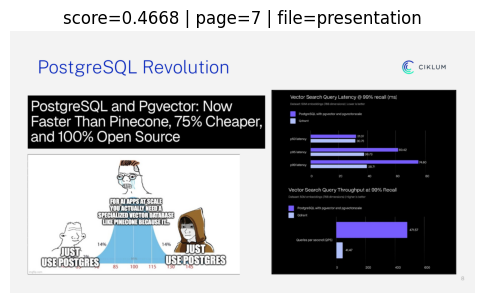

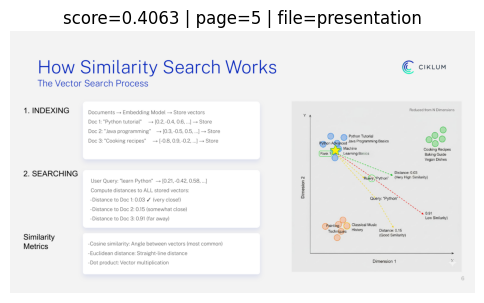

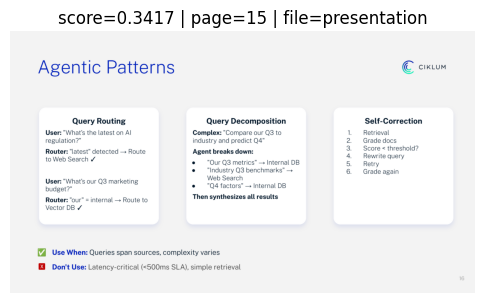

[{'rank': 1,
  'score': 0.46679163,
  'payload': {'pdf_file_name': 'presentation',
   'page_index': 7,
   'image_path': '/Users/gmanvel/repos/rag-genai-dbs-codex/data/pdf_pages/page_0008.png'}},
 {'rank': 2,
  'score': 0.40630084,
  'payload': {'pdf_file_name': 'presentation',
   'page_index': 5,
   'image_path': '/Users/gmanvel/repos/rag-genai-dbs-codex/data/pdf_pages/page_0006.png'}},
 {'rank': 3,
  'score': 0.3416504,
  'payload': {'pdf_file_name': 'presentation',
   'page_index': 15,
   'image_path': '/Users/gmanvel/repos/rag-genai-dbs-codex/data/pdf_pages/page_0016.png'}}]

In [34]:
# Example query; update with a relevant question for your PDF
matches = search_similar("Can I use Postgres for vector search", top_k=3)
matches


## 9. Answer Generation Stub
Outline how to hand retrieved images to a vision-language model for question answering.


In [ ]:
def answer_question_with_vlm(query_text: str, retrieved_results):
    """Pseudocode for sending top results to a VLM such as Qwen2-VL."""
    # Steps:
    # 1. Select the best result, e.g., retrieved_results[0].
    # 2. Load the corresponding page image: Image.open(result['payload']['image_path']).
    # 3. Initialize the VLM (e.g., Qwen2-VL) and format the prompt with the image and query_text.
    # 4. Generate the answer text from the VLM.
    # 5. Return the generated answer string.
    raise NotImplementedError("Integrate with your preferred VLM here.")


## 10. Cleanup
Release model resources so the notebook can be rerun without a kernel restart.


In [ ]:
try:
    del model
except NameError:
    pass

try:
    del processor
except NameError:
    pass

try:
    del page_embeddings
except NameError:
    pass

try:
    torch.cuda.empty_cache()
except Exception:
    pass

try:
    torch.mps.empty_cache()  # type: ignore[attr-defined]
except Exception:
    pass

import gc
_ = gc.collect()

print("Cleanup complete.")
